# Домашнее задание 3. VAE + NF + VAPNEV

### Загрузка данных
В данном задании вам предстоит снова работать с CelebA

Решением домашки является архив с использованными тетрадками/модулями, а так же .pdf файл с отчетом по проделанной работе по каждому пункту задачи. В нем необходимо описать какие эксперименты вы производили чтобы получить результат который вы получили, а так же обосновать почему вы решили использовать штуки которые вы использовали (например, дополнительные лоссы для стабилизации, разные виды потоков, разные хаки для вае)



In [ ]:
# # Для работы в колабе раскоменьте эти строки
# !git clone https://github.com/HSE-LAMBDA/DeepGenerativeModels.git
# %cd DeepGenerativeModels/

In [53]:
# import sys
# sys.path.append('C:\\Users\\platon2612\\Desktop\\hw2_generatives\\utils')

#!g1.1

from celeba import CelebADataset
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import math
from tqdm.auto import trange, tqdm
import os 
from torch import nn

from torch import Tensor

In [4]:
#!g1.1
t_normalize = lambda x: x * 2 - 1
t_invnormalize = lambda x: (x + 1) / 2
transform=transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    t_normalize,
])

In [5]:
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else ("mps" if torch.backends.mps.is_available() else "cpu"))
torch.backends.cudnn.benchmark = cuda

In [55]:
#!g1.1
from random import randint

class CelebaCustomDataset(CelebADataset):
    def __getitem__(self, idx):
        image, target = super().__getitem__(idx)
        return image

batch_size = 128

dataset = CelebaCustomDataset(
    root_dir = "sem/data/celeba/img_align_celeba",
    transform=transform
)
dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=cuda)

img = dataset[0]
img.shape

torch.Size([3, 64, 64])

### Визуализация датасета

In [7]:
#!g1.1
def plot_img(img, transform):
    plt.imshow(transform(img).permute(1, 2, 0))
    plt.axis('off')

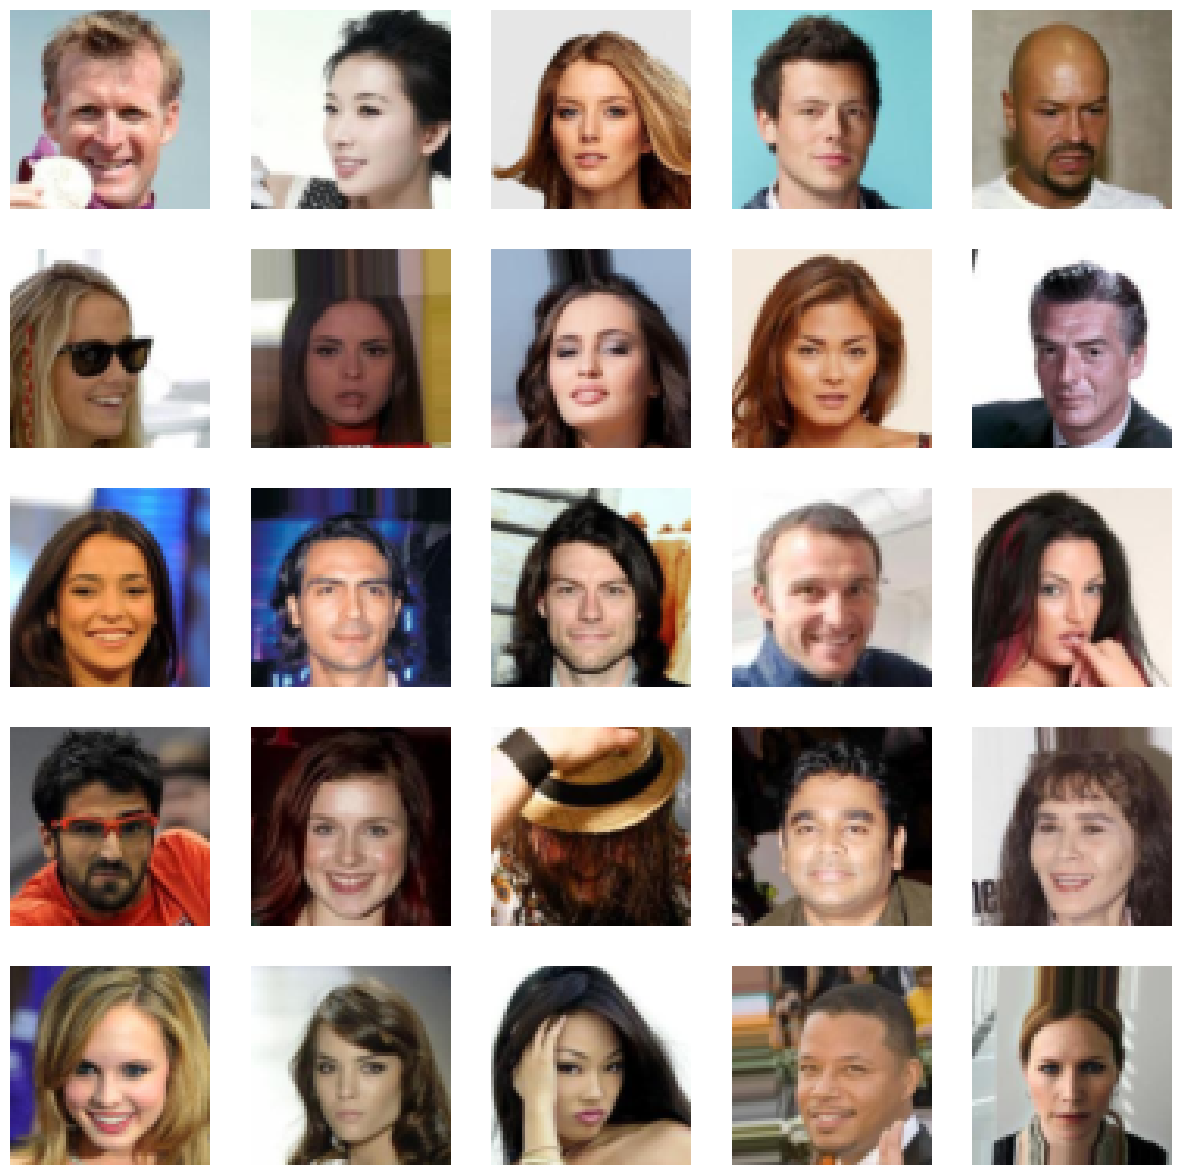

In [8]:
#!g1.1
plt.figure(figsize=(15, 15))

for i in range(25):
    img = dataset[np.random.randint(len(dataset))]
    plt.subplot(5, 5, i + 1)
    plot_img(img, t_invnormalize)
plt.show()

### Задача 1 (4/10 балла). Построить и обучить нормпоток на CelebA

Здесь нужно обучить нормпоток до нормального (трешхолды будут позже) качества, померить FID и Negative Log Likelihood и запомнить для будущего сравнения

Внутри потока можно использовать все что вы хотите, Coupling/Autoregressive/Linear слои, любые трансформации и все что вам приходит в голову. Но все что вы используете - напишите сами, без копипаста.

Можно использовать как и сверточные потоки (будут лучше, но сложнее писать), так и линейные (будут хуже), развернув селебу в один вектор.

В принципе можно использовать тот код который уже есть в репозитории курса, но лучше написать свой

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
from tqdm import tqdm
import torch.optim as optim
from torchvision import transforms
from PIL import Image

class AffineCouplingBlock(nn.Module):
    def __init__(self, input_channels, mid_channels):
        super(AffineCouplingBlock, self).__init__()

        self.transform_net = nn.Sequential(
            nn.Conv2d(input_channels // 2, mid_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(mid_channels, mid_channels, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(mid_channels, input_channels, kernel_size=3, padding=1)
        )
        
        #last layer to zero
        self.transform_net[-1].weight.data.zero_()
        self.transform_net[-1].bias.data.zero_()

    def forward(self, x, invert=False):
        x_part1, x_part2 = x.chunk(2, dim=1)
        
        if not invert:
            log_scale_translation = self.transform_net(x_part2)
            log_scale, translation = log_scale_translation.chunk(2, dim=1)
            scale = torch.sigmoid(log_scale + 2)
            y_part1 = scale * x_part1 + translation
            y_part2 = x_part2
            return torch.cat([y_part1, y_part2], dim=1), torch.sum(torch.log(scale).view(x.shape[0], -1), 1, keepdim=True)
        else:
            log_scale_translation = self.transform_net(x_part2)
            log_scale, translation = log_scale_translation.chunk(2, dim=1)
            scale = torch.sigmoid(log_scale + 2)
            y_part1 = (x_part1 - translation) / scale
            y_part2 = x_part2
            return torch.cat([y_part1, y_part2], dim=1)


class FlowModel(nn.Module):
    def __init__(self, input_channels, mid_channels, num_blocks):
        super(FlowModel, self).__init__()

        self.coupling_blocks = nn.ModuleList([
            AffineCouplingBlock(input_channels, mid_channels) for _ in range(num_blocks)
        ])

    def forward(self, x, invert=False):
        log_determinant = 0
        if not invert:
            for block in self.coupling_blocks:
                x, ld = block(x)
                log_determinant += ld
            return x, log_determinant
        else:
            for block in reversed(self.coupling_blocks):
                x = block(x, invert=True)
            return x




In [10]:
# Training function for the flow model
def train_normalizing_flow(flow_model, data_loader, epochs=10, learning_rate=1e-4, checkpoint_dir="checkpoints", resume_checkpoint=None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    flow_model.to(device)
    optim = torch.optim.Adam(flow_model.parameters(), lr=learning_rate)

    os.makedirs(checkpoint_dir, exist_ok=True)
    
    if resume_checkpoint:
        if os.path.exists(resume_checkpoint):
            checkpoint_data = torch.load(resume_checkpoint, map_location=device)
            flow_model.load_state_dict(checkpoint_data['model_state'])
            optim.load_state_dict(checkpoint_data['optimizer_state'])
            start_epoch = checkpoint_data['epoch']
            print(f"Resumed training from checkpoint.")
        else:
            print(f"Checkpoint not found at {resume_checkpoint}. Starting new training.")
            start_epoch = 0
    else:
        start_epoch = 0
    
    training_step = 0
    
    for epoch in range(start_epoch, epochs):
        flow_model.train()
        progress_bar = tqdm(data_loader, desc=f"Epoch {epoch+1}/{epochs}")
        for data_batch in progress_bar:
            data_batch = data_batch.to(device)
            optim.zero_grad()
            
            transformed_data, log_det_jacobian = flow_model(data_batch)
            
            log_prior = -0.5 * torch.sum(transformed_data**2, dim=[1, 2, 3])
            log_likelihood = log_prior + log_det_jacobian
            
            negative_log_likelihood = -torch.mean(log_likelihood)
            negative_log_likelihood.backward()
            optim.step()
            
            progress_bar.set_postfix(loss=negative_log_likelihood.item())
            
    
    final_checkpoint_path = os.path.join(checkpoint_dir, "final_checkpoint.pt")
    torch.save({
        'epoch': epochs,
        'step': training_step,
        'model_state': flow_model.state_dict(),
        'optimizer_state': optim.state_dict(),
        'loss': negative_log_likelihood.item(),
    }, final_checkpoint_path)
    print(f"Final checkpoint saved at {final_checkpoint_path}")

In [14]:
model_flow = FlowModel(input_channels=3, mid_channels=64, num_blocks=8)
train_normalizing_flow(
    model_flow,
    dataloader,
    epochs=10,
    learning_rate=1e-4,
    checkpoint_dir="checkpoints",
    resume_checkpoint="checkpoints/final_checkpoint.pt"
)

Checkpoint not found at checkpoints\final_checkpoint.pt. Starting new training.


Epoch 10/10: 100%|██████████| 20/20 [01:21<00:00,  4.05s/it, loss=1.61e+3]

Final checkpoint saved at checkpoints/final_checkpoint.pt


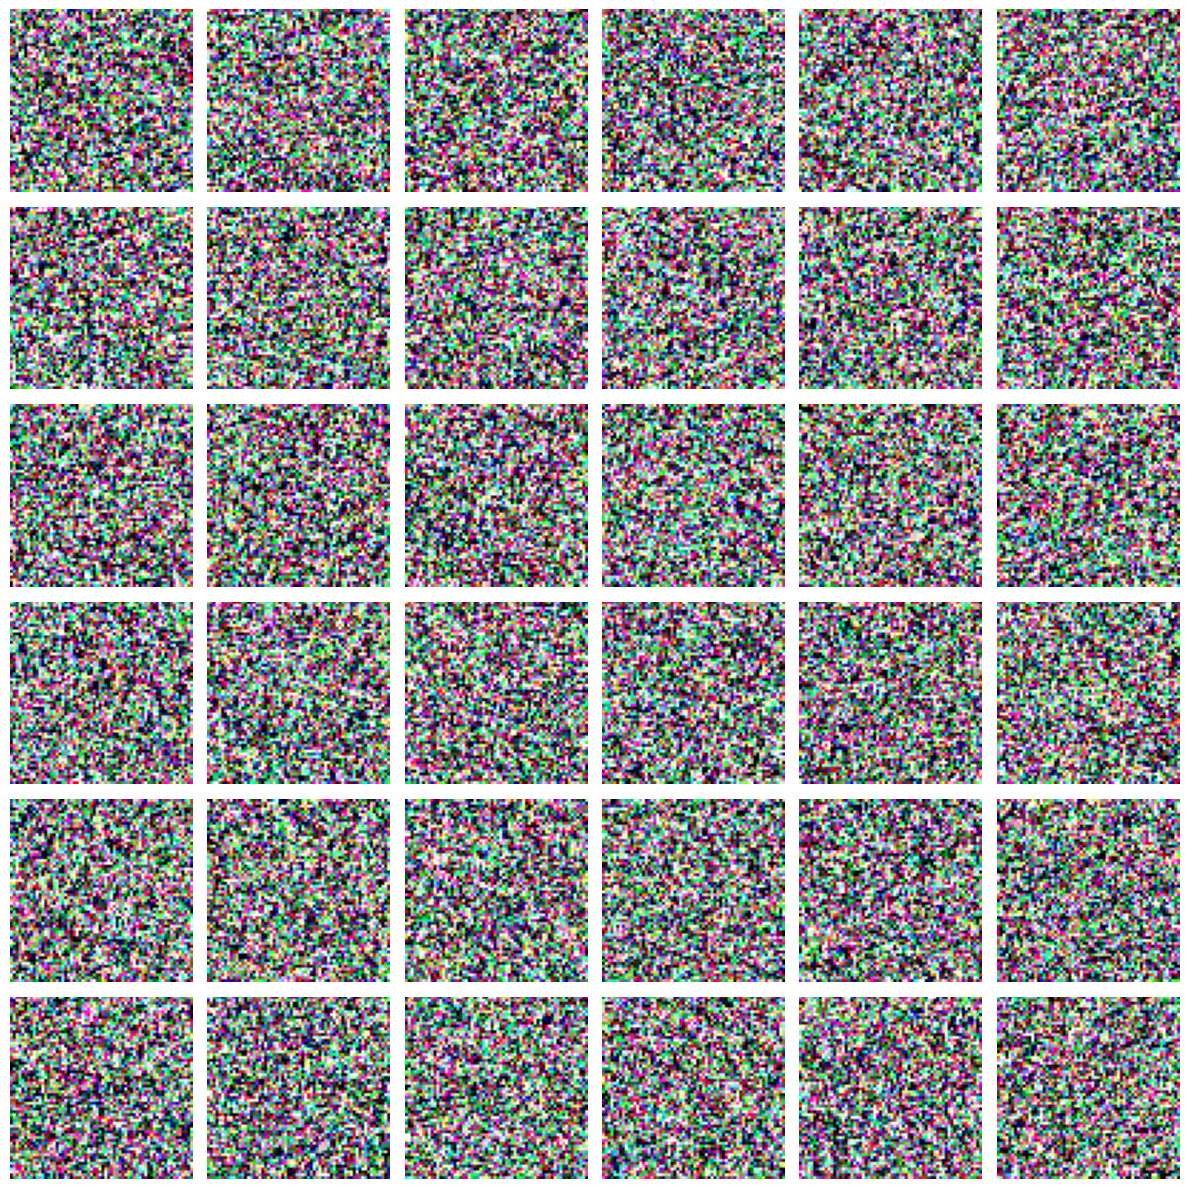

In [19]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def generate_images(model, num_images=64, image_size=(3, 64, 64)):
    device = next(model.parameters()).device
    z = torch.randn(num_images, *image_size).to(device)
    with torch.no_grad():
        generated_images = model(z, invert=True)
    generated_images = generated_images.cpu()
    return generated_images

def plot_images(images, nrows=8, ncols=8):
    images = images.numpy()
    images = np.transpose(images, (0, 2, 3, 1))
    images = (images + 1) / 2
    images = np.clip(images, 0, 1)
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 2, nrows * 2))
    for i, ax in enumerate(axes.flat):
        if i < len(images):
            ax.imshow(images[i])
        ax.axis("off")
    plt.tight_layout()
    plt.show()


model_flow = FlowModel(input_channels=3, mid_channels=64, num_blocks=8)
model_flow.load_state_dict(torch.load("checkpoints/final_checkpoint.pt")["model_state"])
model_flow.eval()

generated_images = generate_images(model_flow, num_images=36)


plot_images(generated_images, nrows=6, ncols=6)

In [22]:
import torch
import numpy as np
import os
import tempfile
from pytorch_fid import fid_score
from torchvision.utils import save_image

# Function to generate images from a model
def create_images(generator_model, total_images=1000, image_dimensions=(3, 64, 64)):
    device = next(generator_model.parameters()).device
    noise_vectors = torch.randn(total_images, *image_dimensions).to(device)
    with torch.no_grad():
        output_images = generator_model(noise_vectors, invert=True)
    output_images = output_images.cpu()
    return output_images

def calculate_fid(generator_model, data_loader, real_image_count=1000, fake_image_count=1000):
    device = next(generator_model.parameters()).device
    
    synthetic_images = create_images(generator_model, total_images=fake_image_count)
    synthetic_images = (synthetic_images + 1) / 2  # Normalize to [0, 1]
    
    genuine_images = []
    for input_batch in data_loader:
        input_batch = input_batch.to(device)
        genuine_images.append(input_batch.cpu())
        if len(genuine_images) * input_batch.size(0) >= real_image_count:
            break
    genuine_images = torch.cat(genuine_images, dim=0)[:real_image_count]
    genuine_images = (genuine_images + 1) / 2  # Normalize to [0, 1]
    
    with tempfile.TemporaryDirectory() as real_image_dir, tempfile.TemporaryDirectory() as fake_image_dir:

        for idx, image in enumerate(genuine_images):
            save_image(image, os.path.join(real_image_dir, f"real_image_{idx}.png"))

        for idx, image in enumerate(synthetic_images):
            save_image(image, os.path.join(fake_image_dir, f"fake_image_{idx}.png"))
        
        fid_result = fid_score.calculate_fid_given_paths(
            [real_image_dir, fake_image_dir],
            batch_size=64,
            device=device,
            dims=2048
        )
    
    return fid_result


In [23]:
model_flow.eval()

fid_value = calculate_fid(model_flow, dataloader, real_image_count=1000, fake_image_count=1000)
print(f"FID: {fid_value}")

100%|██████████| 16/16 [00:52<00:00,  3.25s/it]


FID: 442.5484216279382


### Задача 2 (2/10 балла). Построить и обучить VAE на CelebA

Здесь нужно обучить VAE до нормального качества, померить FID и запомнить для будущего сравнения. 

В принципе можно использовать тот код который уже есть в репозитории курса, но лучше написать свой

Ради интереса, ваше вае тоже можно потестировать на маленьких датасетах


In [75]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import DataLoader, Subset, TensorDataset
from torchvision import transforms
from scipy.linalg import sqrtm
import numpy as np
import os

# Encoder for Variational Autoencoder
class EncoderNN(nn.Module):
    def __init__(self, input_channels, base_channels, latent_size, img_dim):
        super(EncoderNN, self).__init__()
        self.downsample_dim = img_dim // 16
        self.encoder_layers = nn.Sequential(
            nn.Conv2d(input_channels, base_channels, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(base_channels),
            nn.Conv2d(base_channels, base_channels * 2, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(base_channels * 2),
            nn.Conv2d(base_channels * 2, base_channels * 4, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(base_channels * 4),
            nn.Conv2d(base_channels * 4, base_channels * 8, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.mean = nn.Linear(base_channels * 8 * self.downsample_dim * self.downsample_dim, latent_size)
        self.log_variance = nn.Linear(base_channels * 8 * self.downsample_dim * self.downsample_dim, latent_size)

    def forward(self, x):
        batch_size = x.size(0)
        features = self.encoder_layers(x).view(batch_size, -1)
        mu, logvar = self.mean(features), self.log_variance(features)
        return mu, logvar

# Decoder for Variational Autoencoder
class DecoderNN(nn.Module):
    def __init__(self, input_channels, base_channels, latent_size, img_dim):
        super(DecoderNN, self).__init__()
        self.base_channels = base_channels
        self.upsample_dim = img_dim // 16
        self.dense_layer = nn.Sequential(
            nn.Linear(latent_size, base_channels * 8 * self.upsample_dim * self.upsample_dim),
            nn.ReLU(inplace=True)
        )
        self.conv_layers = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(base_channels * 8, base_channels * 4, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(base_channels * 4),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(base_channels * 4, base_channels * 2, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(base_channels * 2),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(base_channels * 2, base_channels, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(base_channels),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(base_channels, input_channels, kernel_size=3, padding=1),
            nn.Tanh()
        )

    def forward(self, latent_vector):
        batch_size = latent_vector.size(0)
        features = self.dense_layer(latent_vector).view(
            batch_size, self.base_channels * 8, self.upsample_dim, self.upsample_dim
        )
        return self.conv_layers(features)

# Variational Autoencoder model definition
class VariationalAutoencoder(nn.Module):
    def __init__(self, input_channels=3, base_channels=32, latent_size=100, img_dim=64):
        super(VariationalAutoencoder, self).__init__()
        self.device = device
        self.latent_size = latent_size
        self.encoder = EncoderNN(input_channels, base_channels, latent_size, img_dim)
        self.decoder = DecoderNN(input_channels, base_channels, latent_size, img_dim)

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparametrize(mu, logvar)
        output_x = self.decoder(z)
        return output_x, mu, logvar

    def sample(self, num_samples):
        z_samp = torch.randn(num_samples, self.latent_size).to(self.device)
        return self.decoder(z_samp)
    
    def encode(self, x):
        mu, logvar = self.encoder(x)
        latent_z = self.reparametrize(mu, logvar)
        return latent_z, mu, logvar

    @staticmethod
    def reparametrize(mu, logvar):
        std = torch.exp(0.5 * logvar)
        epsilon = torch.randn_like(std)
        return mu + epsilon * std

# Define loss function for VAE optimization
def calculate_loss(recon_x, x, mu, logvar, beta=1.0):
    batch_size = recon_x.size(0)
    mse_loss = F.mse_loss(recon_x.view(batch_size, -1), x.view(batch_size, -1), reduction='sum') / batch_size
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / batch_size
    kl_divergence *= beta
    return mse_loss, kl_divergence

# Generate sample images for visualization using VAE
def generate_images(model, sample_count=64):
    with torch.no_grad():
        samples = model.sample(sample_count).cpu()
        image_grid = make_grid(samples, normalize=True)
        return image_grid

# Utility function to display grid of images
def show_images(image_grid, title):
    plt.figure(figsize=(8, 8))
    plt.imshow(image_grid.permute(1, 2, 0))
    plt.axis("off")
    plt.title(title)
    plt.show()

# Train the Variational Autoencoder
def train_vae(vae_model, data_loader, optimizer, scheduler, num_epochs, device, checkpoint_interval=50):
    vae_model.to(device)
    vae_model.train()

    try:
        vae_model.encoder.load_state_dict(torch.load('checkpoints_model_vae/encoder.pth'))
        vae_model.decoder.load_state_dict(torch.load('checkpoints_model_vae/decoder.pth'))
        print("Pretrained weights successfully loaded.")
        return
    except FileNotFoundError:
        print("Weights file not found. Training from scratch.")

    with tqdm(total=num_epochs * len(data_loader), desc="Training Progress") as progress_bar:
        for epoch in range(1, num_epochs + 1):
            running_loss, mse_sum, kl_sum = 0, 0, 0

            for batch_idx, (data, _) in enumerate(data_loader):
                data = data.to(device)
                optimizer.zero_grad()

                reconstructed_batch, mu, logvar = vae_model(data)
                mse_loss, kl_divergence = calculate_loss(reconstructed_batch, data, mu, logvar)
                total_loss = mse_loss + kl_divergence

                total_loss.backward()
                optimizer.step()

                running_loss += total_loss.item()
                mse_sum += mse_loss.item()
                kl_sum += kl_divergence.item()

                if batch_idx % checkpoint_interval == 0:
                    progress_bar.set_description(
                        f"Epoch [{epoch}/{num_epochs}] | KL: {kl_divergence.item()/len(data):.4f} | MSE: {mse_loss.item()/len(data):.4f}"
                    )

                progress_bar.update(1)

            avg_loss = running_loss / len(data_loader.dataset)
            avg_mse = mse_sum / len(data_loader.dataset)
            avg_kl = kl_sum / len(data_loader.dataset)

            print(f"\nEpoch {epoch}/{num_epochs} | Avg Loss: {avg_loss:.4f} | Avg MSE: {avg_mse:.4f} | Avg KL: {avg_kl:.4f}")

            scheduler.step()

            # Save model checkpoints
            torch.save(vae_model.encoder.state_dict(), 'checkpoints_model_vae/encoder.pth')
            torch.save(vae_model.decoder.state_dict(), 'checkpoints_model_vae/decoder.pth')

Pretrained weights successfully loaded.


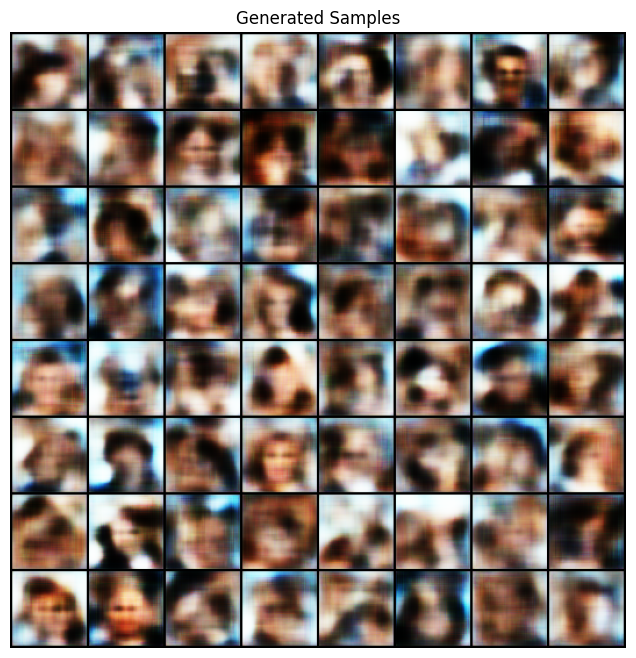

In [78]:
# Define training configuration
input_dim = 64
batch_size = 128

data_transforms = transforms.Compose([
    transforms.Resize((input_dim, input_dim)),
    transforms.ToTensor(),  
    transforms.Normalize([0.5]*3, [0.5]*3),  # Normalize each channel
])

# Initialize dataset and dataloader
celeba_dataset = CelebADataset(root_dir='sem/data/celeba/img_align_celeba', transform=data_transforms)
data_loader = DataLoader(dataset=celeba_dataset, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=cuda)

# Training parameters
epochs_count = 10
learning_rate = 1e-3

# Initialize model, optimizer, scheduler
vae = VariationalAutoencoder().to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs_count)

# Train Variational Autoencoder
train_vae(vae, data_loader, optimizer, scheduler, num_epochs=epochs_count, device=device)


# Generate and display sample images
sample_images = generate_images(vae)
show_images(sample_images, "Generated Samples")

In [26]:
def extract_features(data_loader, encoder, device):
    encoder_representations = []

    encoder.eval()
    latent_dim = encoder.mean.out_features

    with torch.no_grad():
        for batch_images in data_loader:
            images_tensor = batch_images[0].to(device)
            means, _ = encoder(images_tensor)
            flat_embeddings = means.view(means.size(0), latent_dim)
            encoder_representations.append(flat_embeddings.cpu())

    return torch.cat(encoder_representations, dim=0)

def calculate_fid_score(real_features, generated_features):
    real_features = real_features.cpu().numpy()
    generated_features = generated_features.cpu().numpy()

    real_mean, gen_mean = real_features.mean(axis=0), generated_features.mean(axis=0)
    mean_difference = real_mean - gen_mean
    mean_diff_squared_sum = np.sum(mean_difference ** 2)

    real_covariance, gen_covariance = np.cov(real_features, rowvar=False), np.cov(generated_features, rowvar=False)
    covariance_product_sqrt = sqrtm(real_covariance @ gen_covariance)

    # Handle numerical instabilities
    if np.iscomplexobj(covariance_product_sqrt):
        covariance_product_sqrt = covariance_product_sqrt.real

    fid_value = mean_diff_squared_sum + np.trace(real_covariance) + np.trace(gen_covariance) - 2 * np.trace(covariance_product_sqrt)
    return fid_value

In [27]:
# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

vae_encoder = vae.encoder

num_eval_samples = 1000
random_indices = np.random.choice(len(celeba_dataset), num_eval_samples, replace=False)
dataset_subset = Subset(celeba_dataset, random_indices)
loader_for_eval = DataLoader(dataset=dataset_subset, batch_size=128, shuffle=False)

real_image_features = extract_features(loader_for_eval, vae_encoder, device)

vae.eval()
with torch.no_grad():
    fake_images = vae.sample(num_eval_samples).cpu()

generated_image_dataset = TensorDataset(fake_images)
generated_image_loader = DataLoader(generated_image_dataset, batch_size=128, shuffle=False)

generated_features = extract_features(generated_image_loader, vae_encoder, device)

fid_score_value = calculate_fid_score(real_image_features, generated_features)
print(f"FID Score: {fid_score_value:.4f}")

FID Score: 29.6586


### Задача 3 (6/10 балла). 

#### Задача 3.1 (4/10 балла) Построить и обучить VAPNEV на CelebA

Здесь нужно прочитать [статью про VAPNEV](https://arxiv.org/pdf/1611.05209.pdf), обучить его до нормального (трешхолды будут позже) качества, померить FID и запомнить для будущего сравнения. 

#### Задача 3.2 (2/10 балла). Построить и обучить conditional VAPNEV на CelebA

Вроде понятно из текста задачи. Что такое conditional VAPNEV, читайте в статье

In [65]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import CelebA
from torchvision import transforms
from tqdm import tqdm
import numpy as np
from scipy.linalg import sqrtm
import matplotlib.pyplot as plt
from torchvision.models import inception_v3

# Define data loading function and preprocessing
def prepare_dataloader():
    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])


#     class CelebaCustomDataset(CelebADataset):
#         def __getitem__(self, idx):
#             image, target = super().__getitem__(idx)
#             label = torch.tensor(1 if target.get('Smiling', 0) > 0 else 0, dtype=torch.long)
#             return image, label

#     batch_size = 128

#     dataset = CelebaCustomDataset(
#         transform=transform, root_dir = 'sem'
#     )

#     dataloader = DataLoader(
#         dataset, batch_size=32, shuffle=True, num_workers=0
#     )
    class CelebaCustomDataset(CelebADataset):
          def __getitem__(self, idx):
            # Assuming the target is returned as a tensor of binary attributes
            image, target = super().__getitem__(idx)

            # Replace with the index for the "Smiling" attribute as per CelebA's attribute order
            smiling_attr_index = 4  # This index must match the dataset's ordering

            # Convert the target (tensor) to a label (tensor)
            label = torch.tensor(1 if target[smiling_attr_index] > 0 else 0, dtype=torch.long)

            return image, label

    batch_size = 128

    dataset = CelebaCustomDataset(
        root_dir = "sem/data/celeba/img_align_celeba",
        transform=transform
    )
    dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=cuda)
    
    return dataloader



class PlanarFlow(nn.Module):
    def __init__(self, dimension):
        super(PlanarFlow, self).__init__()
        self.u = nn.Parameter(torch.randn(1, dimension) * 0.01)
        self.w = nn.Parameter(torch.randn(1, dimension) * 0.01)
        self.b = nn.Parameter(torch.randn(1) * 0.01)
    
    def forward(self, z):
        uw = torch.sum(self.u * self.w, dim=1)
        m_uw = -1 + torch.log1p(torch.exp(uw.clamp(max=10)))
        u_hat = self.u + (m_uw - uw) * self.w / (torch.sum(self.w ** 2) + 1e-6)
        inner = (z @ self.w.T + self.b).view(-1, 1)
        z_new = z + u_hat * torch.tanh(inner)
        psi = (1 - torch.tanh(inner) ** 2) * self.w
        log_det_jacobian = torch.log(torch.abs(1 + torch.sum(psi * u_hat, dim=1)) + 1e-6)
        return z_new, log_det_jacobian

# Define the loss function for the VAE with planar normalizing flows
def vae_planar_loss(reconstructed, original, mu, logvar, log_det_sum):
    batch_size = original.size(0)
    reconstruction_loss = nn.functional.mse_loss(reconstructed, original, reduction='sum') / batch_size
    kl_divergence = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    log_det_avg = log_det_sum.mean()
    return reconstruction_loss + kl_divergence - log_det_avg

# Calculate FID score function using inception model
def compute_fid(model, dataloader, n_samples=100, device='cpu', conditional=False):
    inception_net = inception_v3(pretrained=True, transform_input=False).to(device)
    inception_net.eval()
    
    def extract_features(images, model):
        with torch.no_grad():
            images = t_invnormalize(images)
            images = images.to(device)
            if images.shape[1] != 3:
                images = images[:, :3, :, :]
            images = torch.nn.functional.interpolate(images, size=(299, 299), mode='bilinear', align_corners=False)
            predictions = model(images)
            return predictions.cpu().numpy()

    model.eval()
    with torch.no_grad():
        latent_z = torch.randn(n_samples, 128).to(device)
        if conditional:
            labels = torch.cat([torch.zeros(n_samples // 2), torch.ones(n_samples // 2)]).long().to(device)
            label_embedding = model.label_embedding(labels)
            conditional_latent = torch.cat([latent_z, label_embedding], dim=1)
            reconstructed_imgs = model.decoder(model.fc_decode(conditional_latent).view(-1, 256, 4, 4)).view(-1, 3 * 64 * 64)
        else:
            reconstructed_imgs = model.decoder(model.fc_decode(latent_z).view(-1, 256, 4, 4)).view(-1, 3 * 64 * 64)
        for flow in model.flows:
            reconstructed_imgs, _ = flow(reconstructed_imgs)
        generated_imgs = reconstructed_imgs.view(-1, 3, 64, 64)
    
    real_imgs = []
    for idx, (images, _) in enumerate(dataloader):
        if len(real_imgs) * dataloader.batch_size >= n_samples:
            break
        real_imgs.append(images)
    real_imgs = torch.cat(real_imgs, dim=0)[:n_samples]
    
    real_feats = extract_features(real_imgs, inception_net)
    fake_feats = extract_features(generated_imgs, inception_net)
    
    mu_real, sigma_real = np.mean(real_feats, axis=0), np.cov(real_feats, rowvar=False)
    mu_fake, sigma_fake = np.mean(fake_feats, axis=0), np.cov(fake_feats, rowvar=False)
    diff = mu_real - mu_fake
    covmean = sqrtm(sigma_real.dot(sigma_fake))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid_value = diff.dot(diff) + np.trace(sigma_real + sigma_fake - 2 * covmean)
    
    return fid_value, generated_imgs

# Display a grid of generated images with FID score
def visualize_generated_images(images, fid_value, n_to_display=64, title='Generated Images'):
    images = t_invnormalize(images)
    plt.figure(figsize=(15, 15))
    for i in range(min(n_to_display, len(images))):
        plt.subplot(8, 8, i+1)
        img = images[i].cpu().permute(1, 2, 0).numpy()
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(f'{title}\nFID Score: {fid_value}')
    plt.show()


### Vapnev Implementation

In [66]:
class VAEWithFlows(nn.Module):
    def __init__(self, latent_dim=128, n_flows=4):
        super(VAEWithFlows, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(64, 128, 4, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(128, 256, 4, stride=2, padding=1), nn.ReLU()
        )
        self.fc_mu = nn.Linear(256 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(256 * 4 * 4, latent_dim)
        self.fc_decode = nn.Linear(latent_dim, 256 * 4 * 4)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1), nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1), nn.Tanh()
        )
        self.flows = nn.ModuleList([PlanarFlow(3 * 64 * 64) for _ in range(n_flows)])
    
    def reparametrize(self, mu, logvar):
        logvar = logvar.clamp(max=10)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        enc_features = self.encoder(x).view(x.size(0), -1)
        mu, logvar = self.fc_mu(enc_features), self.fc_logvar(enc_features)
        latent_z = self.reparametrize(mu, logvar)
        decoded_features = self.fc_decode(latent_z).view(-1, 256, 4, 4)
        decoded_images = self.decoder(decoded_features).view(-1, 3 * 64 * 64)
        log_det_sum = 0
        z_flow = decoded_images
        for flow in self.flows:
            z_flow, log_det = flow(z_flow)
            log_det_sum += log_det
        return z_flow.view(-1, 3, 64, 64), mu, logvar, log_det_sum

def train_vae_with_flows(model, dataloader, epochs=5, max_batches=700, device='cpu'):
    try:
        model.load_state_dict(torch.load('checkpoints_model_vae/model.pth'))
        print(f"Model weights loaded.")
    except FileNotFoundError:
        print(f"Starting training from scratch.")

    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    for epoch in range(epochs):
        model.train()
        cumulative_loss = 0
        print(f'Epoch {epoch}...')
        for batch_idx, (imgs, _) in tqdm(enumerate(dataloader), total=max_batches):
            if batch_idx >= max_batches:
                break
            imgs = imgs.to(device)
            optimizer.zero_grad()
            recon_imgs, mu, logvar, log_det = model(imgs)
            loss = vae_planar_loss(recon_imgs, imgs, mu, logvar, log_det)
            if torch.isnan(loss):
                print("NaN encountered in loss")
                break
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            cumulative_loss += loss.item()
        if torch.isnan(loss):
            break
        print(f"Epoch {epoch+1}, Avg Loss: {cumulative_loss/len(dataloader.dataset)}")
        torch.save(model.state_dict(), 'checkpoints_model_vae/model.pth')

In [67]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataloader = prepare_dataloader()
vae_flow_model = VAEWithFlows(latent_dim=128, n_flows=4).to(device)
train_vae_with_flows(vae_flow_model, dataloader, epochs=5, max_batches=700, device=device)

Starting training from scratch.
Epoch 0...


  3%|▎         | 20/700 [00:11<06:43,  1.69it/s]


Epoch 1, Avg Loss: 27.5754887948441
Epoch 1...


  3%|▎         | 20/700 [00:11<06:33,  1.73it/s]


Epoch 2, Avg Loss: 20.532947336794468
Epoch 2...


  3%|▎         | 20/700 [00:11<06:26,  1.76it/s]


Epoch 3, Avg Loss: 14.487948743675455
Epoch 3...


  3%|▎         | 20/700 [00:11<06:30,  1.74it/s]


Epoch 4, Avg Loss: 11.348856913783692
Epoch 4...


  3%|▎         | 20/700 [00:11<06:33,  1.73it/s]

Epoch 5, Avg Loss: 9.30120652425925


/home/platon2612/.local/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/home/platon2612/.local/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /home/platon2612/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

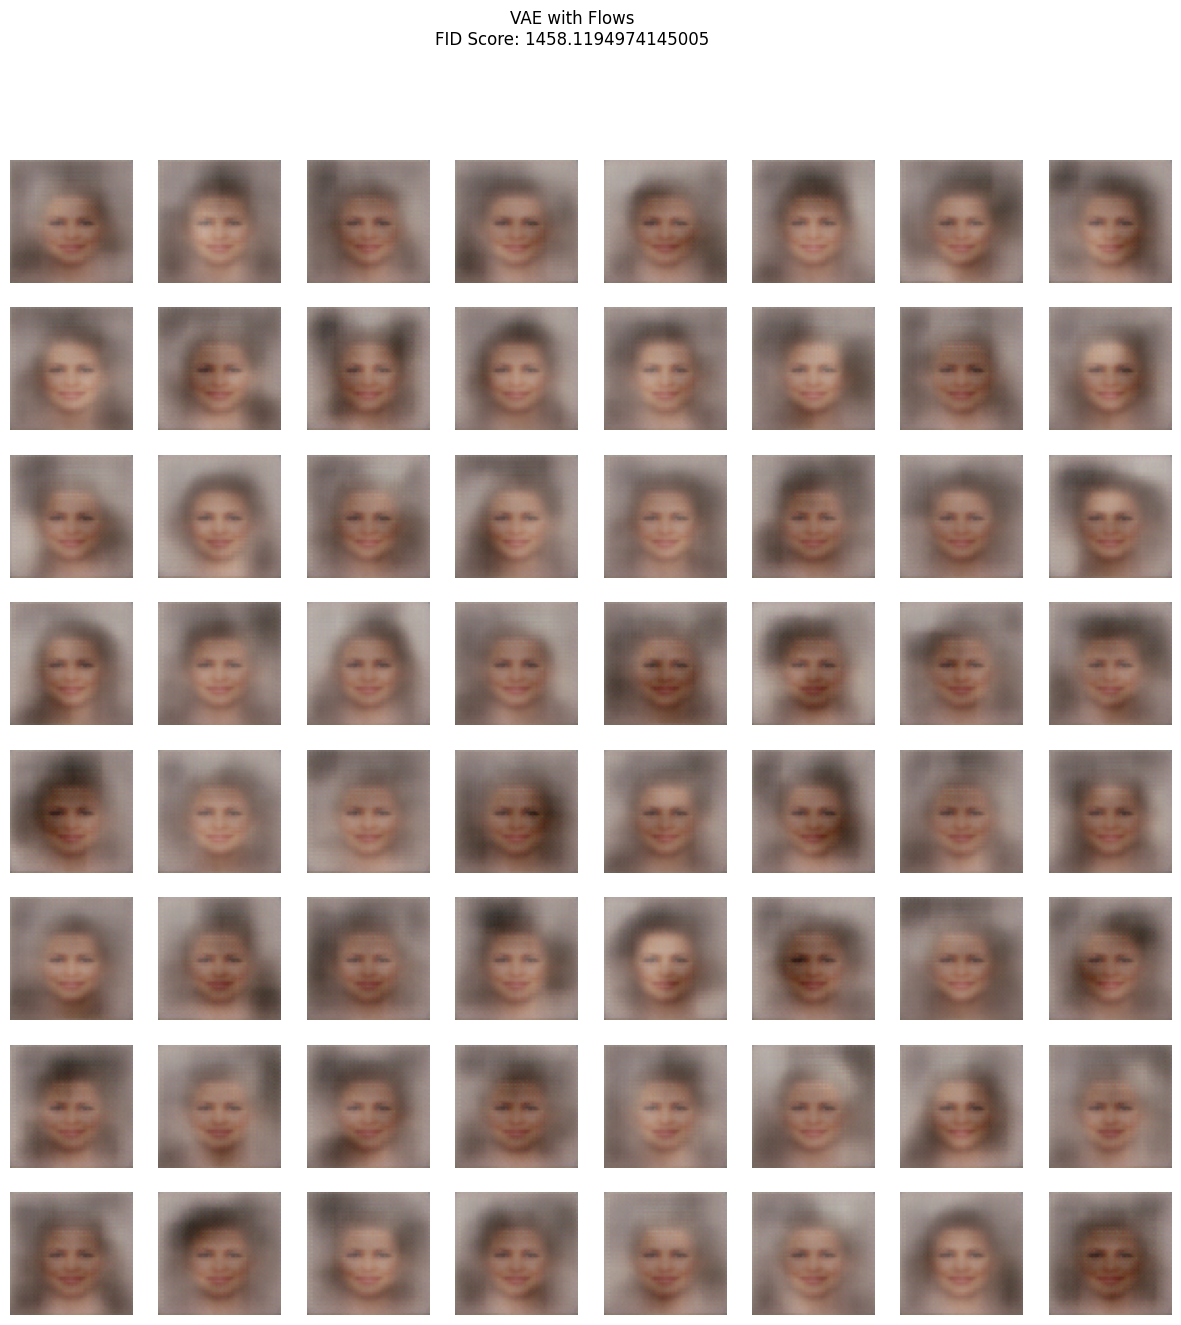

In [68]:
fid_value, sampled_images = compute_fid(vae_flow_model, dataloader, n_samples=64, device=device, conditional=False)
visualize_generated_images(sampled_images, fid_value, title='VAE with Flows')

In [69]:
print(f"VAE with Flows FID Score: {fid_value}")

VAE with Flows FID Score: 1458.1194974145005


### Conditional Vapnev Implementation

In [70]:
class ConditionalVAEWithFlows(nn.Module):
    def __init__(self, latent_dim=128, n_flows=4, n_classes=2):
        super(ConditionalVAEWithFlows, self).__init__()
        self.label_embedding = nn.Embedding(n_classes, latent_dim)
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(64, 128, 4, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(128, 256, 4, stride=2, padding=1), nn.ReLU()
        )
        self.fc_mu = nn.Linear(256 * 4 * 4 + latent_dim, latent_dim)
        self.fc_logvar = nn.Linear(256 * 4 * 4 + latent_dim, latent_dim)
        self.fc_decode = nn.Linear(latent_dim + latent_dim, 256 * 4 * 4)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1), nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1), nn.Tanh()
        )
        self.flows = nn.ModuleList([PlanarFlow(3 * 64 * 64) for _ in range(n_flows)])
    
    def reparametrize(self, mu, logvar):
        logvar = logvar.clamp(max=10)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x, labels):
        label_embedding = self.label_embedding(labels)
        enc_features = self.encoder(x).view(x.size(0), -1)
        combined_features = torch.cat([enc_features, label_embedding], dim=1)
        mu, logvar = self.fc_mu(combined_features), self.fc_logvar(combined_features)
        latent_z = self.reparametrize(mu, logvar)
        cond_latent_z = torch.cat([latent_z, label_embedding], dim=1)
        decoded_features = self.fc_decode(cond_latent_z).view(-1, 256, 4, 4)
        decoded_imgs = self.decoder(decoded_features).view(-1, 3 * 64 * 64)
        log_det_jacobian = 0
        z_flow = decoded_imgs
        for flow in self.flows:
            z_flow, log_det = flow(z_flow)
            log_det_jacobian += log_det
        return z_flow.view(-1, 3, 64, 64), mu, logvar, log_det_jacobian

def train_conditional_vae_with_flows(model, dataloader, epochs=5, max_batches=700, device='cpu'):
    try:
        model.load_state_dict(torch.load('checkpoints_model_vae_cond/model.pth'))
        print(f"Model weights loaded.")
    except FileNotFoundError:
        print(f"Starting conditional training from scratch.")
    
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    for epoch in range(epochs):
        model.train()
        cumulative_loss = 0
        print(f'Epoch {epoch}...')
        for batch_idx, (imgs, labels) in tqdm(enumerate(dataloader), total=max_batches):
            if batch_idx >= max_batches:
                break
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            recon_imgs, mu, logvar, log_det = model(imgs, labels)
            loss = vae_planar_loss(recon_imgs, imgs, mu, logvar, log_det)
            if torch.isnan(loss):
                print("NaN encountered in loss")
                break
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            cumulative_loss += loss.item()
        if torch.isnan(loss):
            break
        print(f"Epoch {epoch+1}, Avg Loss: {cumulative_loss/len(dataloader.dataset)}")
        torch.save(model.state_dict(), 'checkpoints_model_vae_cond/model.pth')

In [71]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataloader = prepare_dataloader()
conditional_vae_flow_model = ConditionalVAEWithFlows(latent_dim=128, n_flows=4, n_classes=2).to(device)
train_conditional_vae_with_flows(conditional_vae_flow_model, dataloader, epochs=5, max_batches=700, device=device)

Starting conditional training from scratch.
Epoch 0...


  3%|▎         | 20/700 [00:11<06:36,  1.71it/s]


Epoch 1, Avg Loss: 27.68514370362979
Epoch 1...


  3%|▎         | 20/700 [00:11<06:45,  1.68it/s]


Epoch 2, Avg Loss: 16.748236079398712
Epoch 2...


  3%|▎         | 20/700 [00:11<06:35,  1.72it/s]


Epoch 3, Avg Loss: 11.874281793676042
Epoch 3...


  3%|▎         | 20/700 [00:11<06:47,  1.67it/s]


Epoch 4, Avg Loss: 10.317877330249813
Epoch 4...


  3%|▎         | 20/700 [00:11<06:34,  1.72it/s]

Epoch 5, Avg Loss: 9.488402540750023


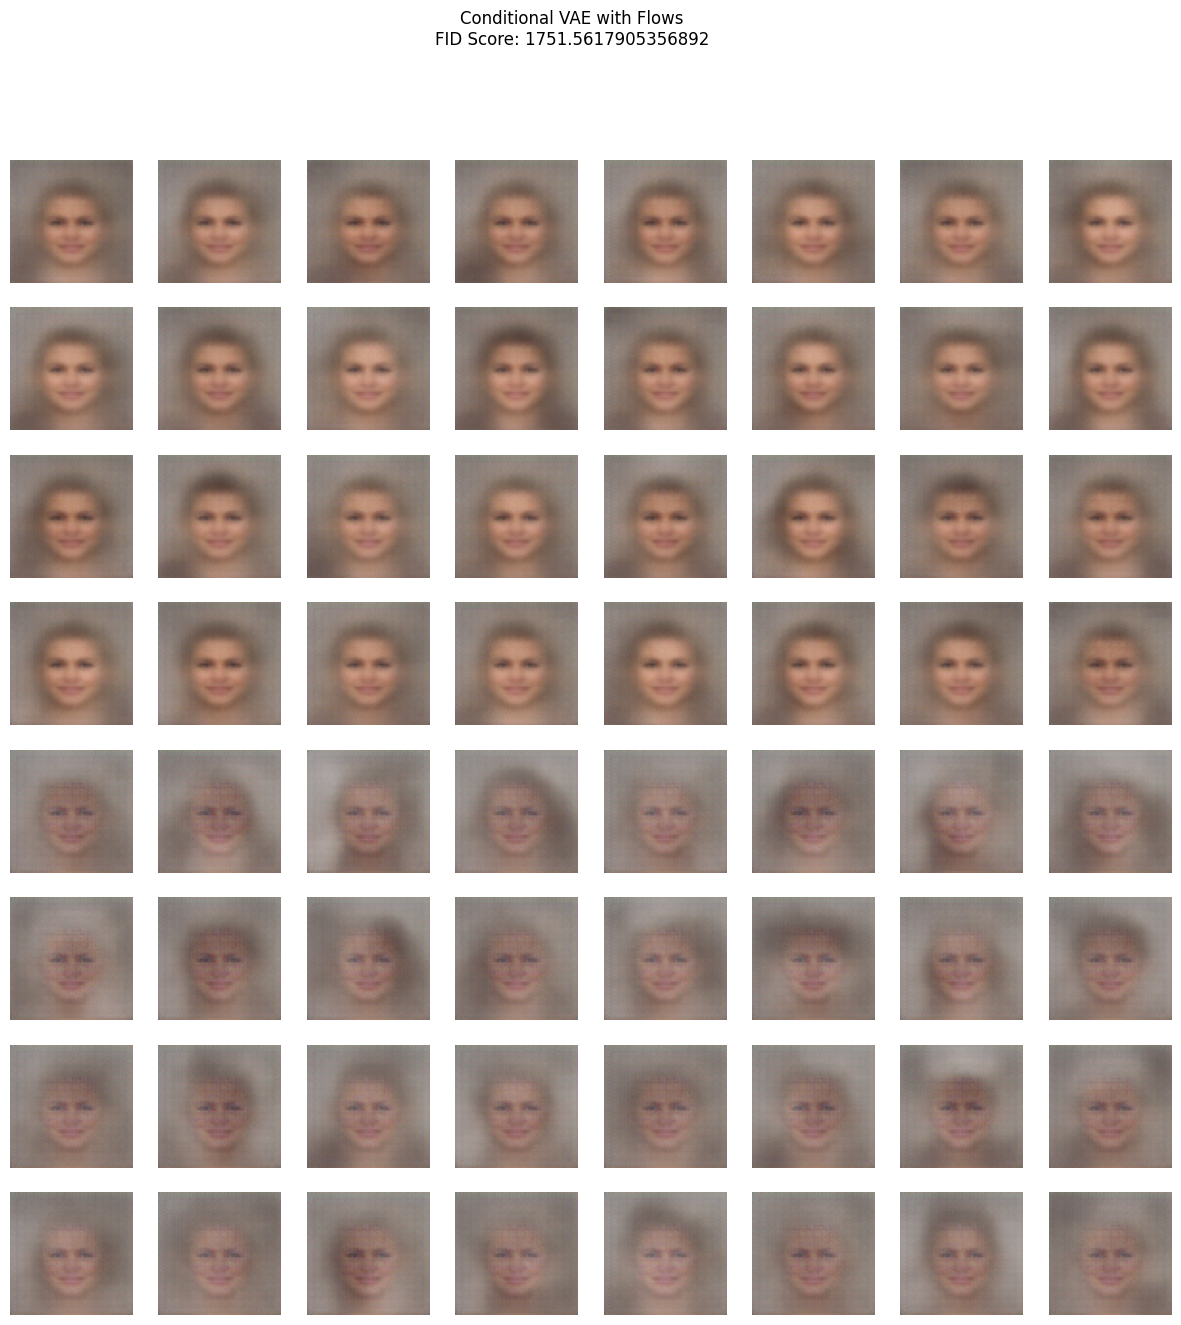

In [72]:
fid_value_cond, sampled_images_cond = compute_fid(conditional_vae_flow_model, dataloader, n_samples=64, device=device, conditional=True)
visualize_generated_images(sampled_images_cond, fid_value_cond, title='Conditional VAE with Flows')

In [73]:
print(f"Conditional VAE with Flows FID Score: {fid_value_cond}")

Conditional VAE with Flows FID Score: 1751.5617905356892


### Задача 4. (1/10 балла) Анализ

* Анализ латентного пространства и визуально качественный результат - **1 балл**
1. Посмотрите у какой модели получается лучшая интерполяция в латентном пространстве
2. Попробуйте взять внешнюю картинку (не из селебы), отмапить ее с латентное пространство и покажите ближайшие к ней.
3. Покажите самый смешной результат генерации который у вас получался

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


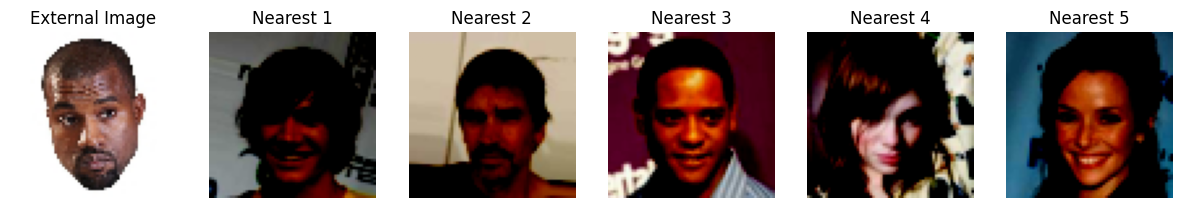

In [87]:
from PIL import Image
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset

def encode_image(model, image, device):
    image = image.unsqueeze(0)
    return model.encode(image.to(device))

def calculate_distances(z_external, dataloader, model, device):
    distances = []
    all_images = []
    for batch in dataloader:
        images = batch[0].to(device)
        # Ensure images are in 4D format
        if images.dim() == 3:
            images = images.unsqueeze(0)
        z, _, _ = model.encode(images)
        batch_distances = torch.norm(z_external - z, dim=1).detach().cpu().numpy()
        distances.extend(batch_distances)
        all_images.extend(images.cpu())
    return distances, all_images

def display_images(external_image, nearest_images, num_neighbors):
    plt.figure(figsize=(15, 3))
    plt.subplot(1, num_neighbors + 1, 1)
    plt.imshow(external_image.permute(1, 2, 0).cpu().numpy())
    plt.title("External Image")
    plt.axis("off")

    for i, img in enumerate(nearest_images):
        plt.subplot(1, num_neighbors + 1, i + 2)
        plt.imshow(img.permute(1, 2, 0).numpy())
        plt.title(f"Nearest {i + 1}")
        plt.axis("off")
    plt.show()

def find_nearest_images(model, external_image, subset, device, num_neighbors=5):
    z_external, _, _ = encode_image(model, external_image, device)
    dataloader = DataLoader(dataset=subset, batch_size=128, shuffle=False)
    distances, all_images = calculate_distances(z_external, dataloader, model, device)
    nearest_indices = np.argsort(distances)[:num_neighbors]
    nearest_images = [all_images[i] for i in nearest_indices]
    display_images(external_image, nearest_images, num_neighbors)

def load_and_transform_image(image_path, transform, device):
    image = Image.open(image_path)
    if image.mode == "RGBA":
        image = image.convert("RGB")
    return transform(image).to(device)

def create_random_subset(dataset, num_samples):
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    return Subset(dataset, indices)

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x[:3])
])

image_path = "photo_model.jpg"
external_image = load_and_transform_image(image_path, transform, device)

num_samples = 1000
subset = create_random_subset(dataset, num_samples)

find_nearest_images(vae, external_image, subset, device)

### Задача 0. Отчет

Чтобы получить полный балл за каждый из пунктов вам нужно включить в отчет (который сдатеся отдельно в виде pdf) примеры (лучше - много примеров) генерации вашей модели. 

Сравните результаты разных моделей, попробуйте обьяснить почему одна сработала лучше чем другая.

In [ ]:
Отчёт см в пдф файле